<div style="color:#8b1538; font-size:32px;">Graphic representation using matplotlib and seaborn</div>

In [1]:
import ast
import json
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sei.files.files as f
import sei.simulation.msprime as ms

<br>

# SFS shape verification

> Generate data

In [2]:
def simulation_parameters(sample, ne, rcb_rate, mu, length):
    """
    Set up the parametres for the simulation with msprime.
    """
    parameters = {
        "sample_size": sample, "size_population": ne, "rcb_rate": rcb_rate, "mu": mu,
        "length": length
    }
    return parameters


def generate_sfs():
    """
    Return
    ------
    sfs: dictionary
        sfs for various scenario - constant population, theorical sfs for any constant population, decline model,
        growth model and migration model (with no migration finto 2 from 1)
    parameters: dictionary
        specific value of tau & kappa for the growth and decline model
        specifiv value of m12, m21 & kappa for the migration model
    """
    # Dictionary
    sfs, parameters = {}, {}
    
    # Parameters for the simulation
    params_simulation = simulation_parameters(sample=10, ne=1, rcb_rate=2e-2, mu=2e-2, length=1e5)

    # Constant scenario
    sfs_cst = ms.msprime_simulation(model=ms.constant_model, params=params_simulation, debug=True)
    sfs['Constant model'] = sfs_cst
    
    # Theoretical SFS for any constant population
    sfs_theorique = [0] * (params_simulation["sample_size"] - 1)
    for i in range(len(sfs_theorique)):
        sfs_theorique[i] = 1 / (i+1)
    sfs['Theoretical model'] = sfs_theorique

    # Define tau & kappa for decline/growth scenario
    params_simulation.update({"Tau": 1.0, "Kappa": 10.0})

    sfs['Decline model'] = ms.msprime_simulation(model=ms.sudden_decline_model, params=params_simulation, debug=True)
    parameters['Decline model'] = {k: v for k, v in params_simulation.items() if k in ['Tau', 'Kappa']}

    sfs['Growth model'] = ms.msprime_simulation(model=ms.sudden_growth_model, params=params_simulation, debug=True)
    parameters['Growth model'] = {k: v for k, v in params_simulation.items() if k in ['Tau', 'Kappa']}

    # Migration scenario
    params_simulation.update({"Kappa": 10.0, "m12": 1.0, "m21": 0})
    
    sfs['Migration model'] = ms.msprime_simulation(model=ms.two_pops_migration_model, params=params_simulation, debug=True)
    parameters['Migration model'] = {k: v for k, v in params_simulation.items() if k in ['m12', 'm21', 'Kappa']}

    return sfs, parameters, {k: v for k, v in params_simulation.items() if k not in ['m12', 'm21', 'Kappa', 'Tau']}


def load_sfs(generate=False):
    if generate:
        all_sfs, params, params_simulation = generate_sfs()
        with open("./Data/Msprime/sfs_shape_verification", 'w') as filout:
            filout.write("SFS shape verification and simulations parameters - {}\n".format(params_simulation))
           
            for model, sfs in all_sfs.items():
                if model in params.keys():
                    filout.write("{} - {} - {}\n".format(model, sfs, params[model]))
                else:
                    filout.write("{} - {}\n".format(model, sfs))
    
    else:
        all_sfs, params = {}, {}
        with open("./Data/Msprime/sfs_shape_verification", 'r') as filin:
            lines = filin.readlines()
            params_simulation = ast.literal_eval(lines[0].strip().split(' - ')[1])
            
            for line in lines[1:]:
                tmp = line.strip().split(' - ')
                if tmp[0] not in ['Constant model', 'Theoretical model']:
                    params[tmp[0]] = ast.literal_eval(tmp[2])
                all_sfs[tmp[0]] = json.loads(tmp[1])
        
    return all_sfs, params, params_simulation

In [3]:
data = load_sfs()

<br>

> Plot data

In [4]:
def plot_sfs(data):
    """
    Graphic representation of Site Frequency Spectrum (SFS), save to the folder ./Figures.

    Parameter
    ---------
    sfs: list
        list of sfs to plot
    label: list
        the label of each sfs
    color: list
        the color of each curve
    style: list
        the linestyle
    title: string
        title of the plot
    """
    color = ["tab:blue", "tab:orange", "tab:red", "tab:green", "tab:gray"]
    
    # Set up plot
    plt.figure(figsize=(12,9), constrained_layout=True)
    
    cpt = 0
    for key, sfs in data[0].items():
        # Normalization of SFS - sum to 1
        normalized_sfs = [ele / sum(sfs) for ele in sfs]
        
        # Label
        if key in ['Constant model', 'Theoretical model']:
            label = key
        else:
            label = "{} - {}".format(key, data[1][key])
    
        # Plot
        plt.plot(normalized_sfs, color=color[cpt], label=label)
        
        cpt += 1
        
    # Caption
    plt.legend(loc="upper right", fontsize="x-large")

    # Label axis
    plt.xlabel("Allele frequency", fontsize="x-large")
    plt.ylabel("Percent of SNPs", fontsize="x-large")

    # X axis values
    x_ax, x_values = [], []
    for i in range(len(sfs)):
        x_ax.append(i)
        x_values.append("{}/{}".format(i+1, len(sfs)+1))
    plt.xticks(x_ax, x_values)

    # Title + show
    title = "Unfold SFS for various scenario with Ne={}, mu={}, rcb={}, L={}" \
        .format(data[2]['size_population'], data[2]['mu'], data[2]['rcb_rate'], data[2]['length'])
    plt.title(title, fontsize="xx-large")
    plt.show()

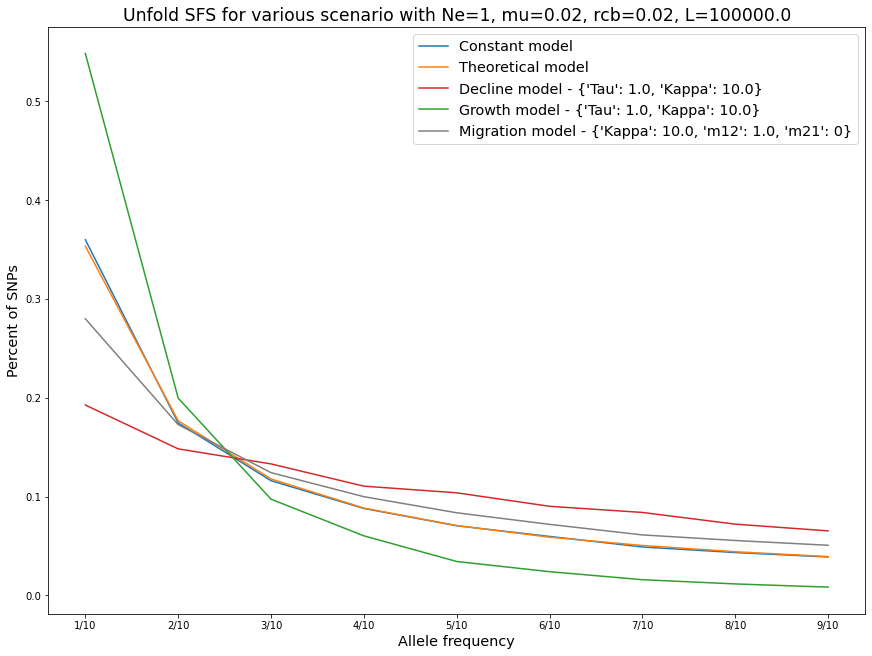

In [5]:
plot_sfs(data)

<br>

# SNPs distribution

> Load data

In [192]:
def load_data(model, path_data):
    data = pd.read_json(path_or_buf="{}SFS_{}-all.json".format(path_data, model), typ='frame')
    
    return data

<br>

> Data pre-processing

In [193]:
def percentile(centile):
    
    def percentile_(data):
        return np.percentile([np.log10(ele) for ele in data], centile)
    percentile_.__name__ = "centile {}%".format(centile)
    
    return percentile_

In [194]:
def data_preprocessing(sfs):
    """
    Pre processing for the plot.
    """
    # New pandas DataFrame
    data = pd.DataFrame()
    
    # Compute log10 of parameters - either (tau, kappa) or (m12, kappa)
    keys = sfs['Parameters'][0].keys()
    name = []
    for key in keys:
        if key in ['Tau', 'Kappa', 'm12']:
            name.append(key)
            data[key] = sfs['Parameters'].apply(lambda ele: ele[key])
    
    # Compute mean(SNPs)
    data['SNPs'] = sfs['SNPs']
    
    # Compute 
    data = data.groupby([name[0], name[1]]).agg([percentile(50)]).unstack(name[0])
    data.columns.name = data.columns.names[2]
    
    return data

<br>

> Plot data

In [195]:
def plot_snp_distribution(data, model):
    # Set-up plot
    plt.figure(figsize=(12,9), constrained_layout=True)
    sns.set_theme(style='whitegrid')

    # Plot
    ax = sns.heatmap(data)
    
    # Name
    names = ["Log10({})".format(data.columns.name), "Log10({})".format(data.index.name)]
    
    # x-axis
    plt.xticks(np.arange(64, step=7) + 0.5, labels=[round(ele, 2) for ele in np.arange(-4, 2.5, 0.7)], rotation='horizontal')
    plt.xlabel(names[0], fontsize="large")
    
    # y-axis
    ax.set_ylim(ax.get_ylim()[::-1])  # reverse y-axis
    plt.yticks(np.arange(64, step=7) + 0.5, labels=[round(ele, 2) for ele in np.arange(-3.5, 3, 0.7)])
    plt.ylabel(names[1], fontsize="large")
    
    # Title
    title = "SNPs distribution in terms of {} & {} - {} model".format(names[0], names[1], model)
    plt.title(title, fontsize="x-large", color="#8b1538")
    
    plt.show()

<br>

### SNPs distribution - decline model

> By default

In [196]:
model, path_data = "decline", "./Data/Msprime/snp_distribution/sfs_decline-default/"
data = data_preprocessing(load_data(model, path_data))

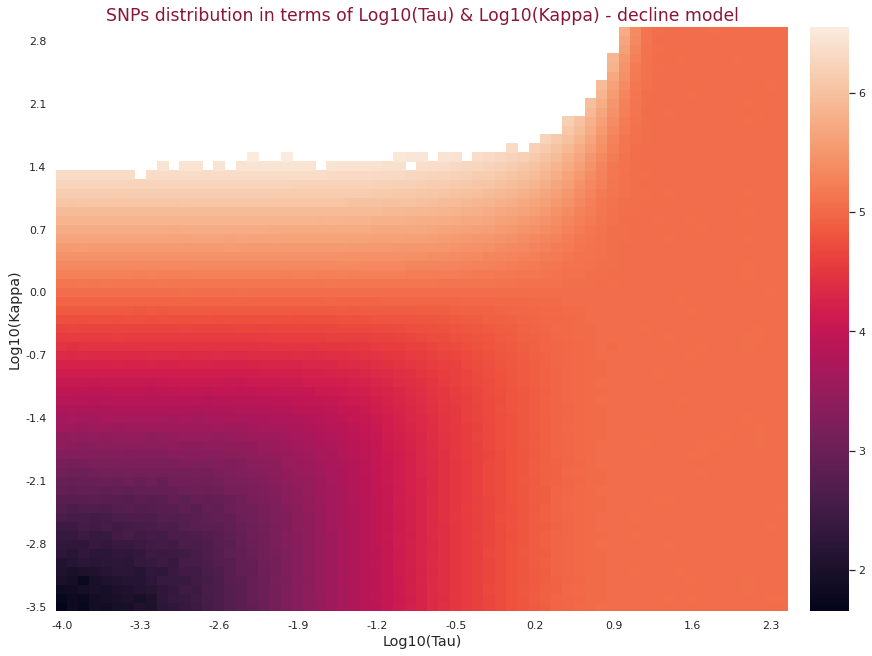

In [197]:
plot_snp_distribution(data, model)

<br>

> About 100 000 SNPs for each observed SFS

In [201]:
model, path_data = "decline", "./Data/Msprime/snp_distribution/sfs_decline/"
data = data_preprocessing(load_data(model, path_data))

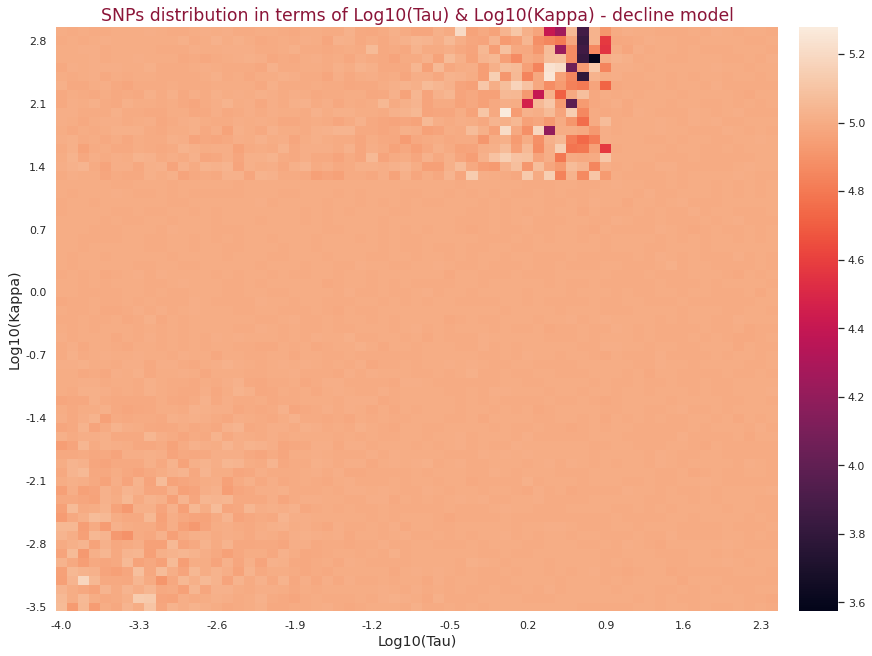

In [202]:
plot_snp_distribution(data, model)

<br>

# Load data

> Dadi

In [8]:
f.export_inference_files('decline', 'all')

,Parameters,Positive hit,SNPs,SFS observed,M0,M1,Time
0,"{'Tau': 0.0006309573, 'Kappa': 794.3282347243}","[0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[113150, 116532, 114647, 116306, 116412, 11620...","[[0, 30953, 16069, 10868, 8137, 6273, 5294, 45...","{'LL': [-136.8959347368, -126.6911593932, -118...","{'LL': [-136.8959347404, -126.9055978881, -115...",0.7486


<br>

# Weighted square distance

The weighted square distance $\large{d^2}$ is:

1. Between the observed SFS $\large{\eta^{obs}}$ and the predicted SFS by model M1 $\large{\eta^{model}}$

\begin{equation}
\Large{ d^2(\eta^{model}, \eta^{obs}) = \sum_{i=1}^{n}{\frac{(\eta^{model}_i - \eta^{obs}_i)^2}{\eta^{model}_i }} }
\end{equation}

2. Between the inferred SFS of two models ($\large{\eta^{m2}}$ & $\large{\eta^{m1}}$)

\begin{equation}
\Large{ d^2(\eta^{m0}, \eta^{m1}) = \sum_{i=1}^{n}{\frac{(\eta^{m0}_i - \eta^{m1}_i)^2}{ (\eta^{m0}_i + \eta^{m1}_i) / 2 }} }
\end{equation}

Start the sum from 2 to ignore singletion (i=2).

<div class="alert alert-warning">Each SFS must be normalized for comparison</div>

In [113]:
def normalization(sfs):
    """
    Return a normalized sfs
    """
    return [ele / sum(sfs) for ele in sfs]


def compute_weighted_square_distance(sfs):
    if "Observed" in sfs.keys():
        d2 = [
            np.power(eta_model - eta_obs, 2) / eta_model for eta_obs, eta_model in zip(sfs['Observed'], sfs['Model'])
        ]
    else:
        d2 = [
            np.power(eta_m0 - eta_m1, 2) / (np.mean([eta_m0, eta_m1])) for eta_m0, eta_m1 in zip(sfs['M0'], sfs['M1'])
        ]
    return sum(d2)


def data_weighted_square_distance(data):
    # Pre-processing data
    # 1. Normalization
    data['SFS observed'] = df['SFS observed'].apply(lambda x: [normalization(ele) for ele in x])
    data['M0'] = df['M0'].apply(
        lambda x: {k: ([normalization(ele) for ele in v] if k == 'SFS' else v) for k, v in x.items()}
    )
    data['M1'] = df['M1'].apply(
        lambda x: {k: ([normalization(ele) for ele in v] if k == 'SFS' else v) for k, v in x.items()}
    )
    
    # 2. Compute weighted square distance
    d2_observed_inferred = {}  # d2 between the observed SFS and inferred one with M1
    d2_models = {}  # d2 between the inferred SFS of two models (M0 & M1)
    
    for i, row in data.iterrows():
        
        # Iterate over all the normalized observed SFS & normalized inferred SFS with M1
        tmp = []
        for sfs_observed, sfs_inferred in zip(row['SFS observed'], row['M1']['SFS']):
            tmp.append(compute_weighted_square_distance({'Observed': sfs_observed, 'Model': sfs_inferred}))
        d2_observed_inferred[i] = tmp
        
        # Iterate over all the normalized inferred SFS with M0 & M1
        tmp = []
        for sfs_m0, sfs_m1 in zip(row['M0']['SFS'], row['M1']['SFS']):
            tmp.append(compute_weighted_square_distance({'M0': sfs_m0, 'M1': sfs_m1}))
        d2_models[i] = tmp
        
    # Add new columns to DataFrame data from dictionary
    data['d2 observed inferred'] = pd.Series(d2_observed_inferred)
    data['d2 models'] = pd.Series(d2_models)
        
    # Compute log 10 of tau
    data['Tau'] = data['Parameters'].apply(lambda ele: np.log10(ele['Tau']))

    return data

data = data_weighted_square_distance(f.export_inference_files('decline', 'tau', 1.0))

In [116]:
data

,Parameters,Positive hit,SNPs,SFS observed,M0,M1,Time,d2 observed inferred,d2 models,Tau
0,"{'Tau': 1.0, 'Kappa': 19.9526231497}","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[99518, 101285, 100295, 94423, 96422, 98998, 1...","[[0.0, 0.1059506822886312, 0.08166361864185373...","{'LL': [-16835.421163712, -16050.0082708769, -...","{'LL': [-693.8876152599, -835.6560738879, -692...",0.0111,"[0.1455143866997548, 0.15317889540563373, 0.14...","[0.3206973721386342, 0.3027383710215121, 0.380...",0.0
1,"{'Tau': 1.0, 'Kappa': 0.0006309573}","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[98350, 99026, 98709, 98094, 99363, 98570, 989...","[[0.0, 0.4552414844941535, 0.20061006609049314...","{'LL': [-19806.8129994295, -19925.215292459, -...","{'LL': [-6584.5242782956, -6996.5258428032, -6...",0.0100,"[0.9942546959376499, 1.00643083988779, 1.00001...","[0.09809806040972166, 0.09070130234797082, 0.0...",0.0
2,"{'Tau': 1.0, 'Kappa': 0.1258925412}","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[99015, 100076, 98825, 100151, 101544, 100276,...","[[0.0, 0.41773468666363683, 0.1844770994293794...","{'LL': [-10884.0132043511, -11546.0154801142, ...","{'LL': [-1696.7261679159, -2177.4355355518, -2...",0.0106,"[0.8083782069580437, 0.8329239867028865, 0.817...","[0.10076110814615331, 0.09256233617384993, 0.0...",0.0
